In [ ]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
from matplotlib import ticker
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# For reproducability
SEED = 51432
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

# Customize matplotlib graphs
plt.rc("axes.spines", right=False, top=False)
plt.rc("font", family="serif", size=10.5)

In [ ]:
#Importing all the necessary libraries for image processing
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, Callback , ModelCheckpoint
from tensorflow.keras.metrics import Accuracy,binary_crossentropy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Introduction
Breast cancer is the most prevalent form of cancer, accounting for 2,261,419 (11.7%) of the 19,292,789 cases reported worldwide in 2020 - Global Cancer Observatory.

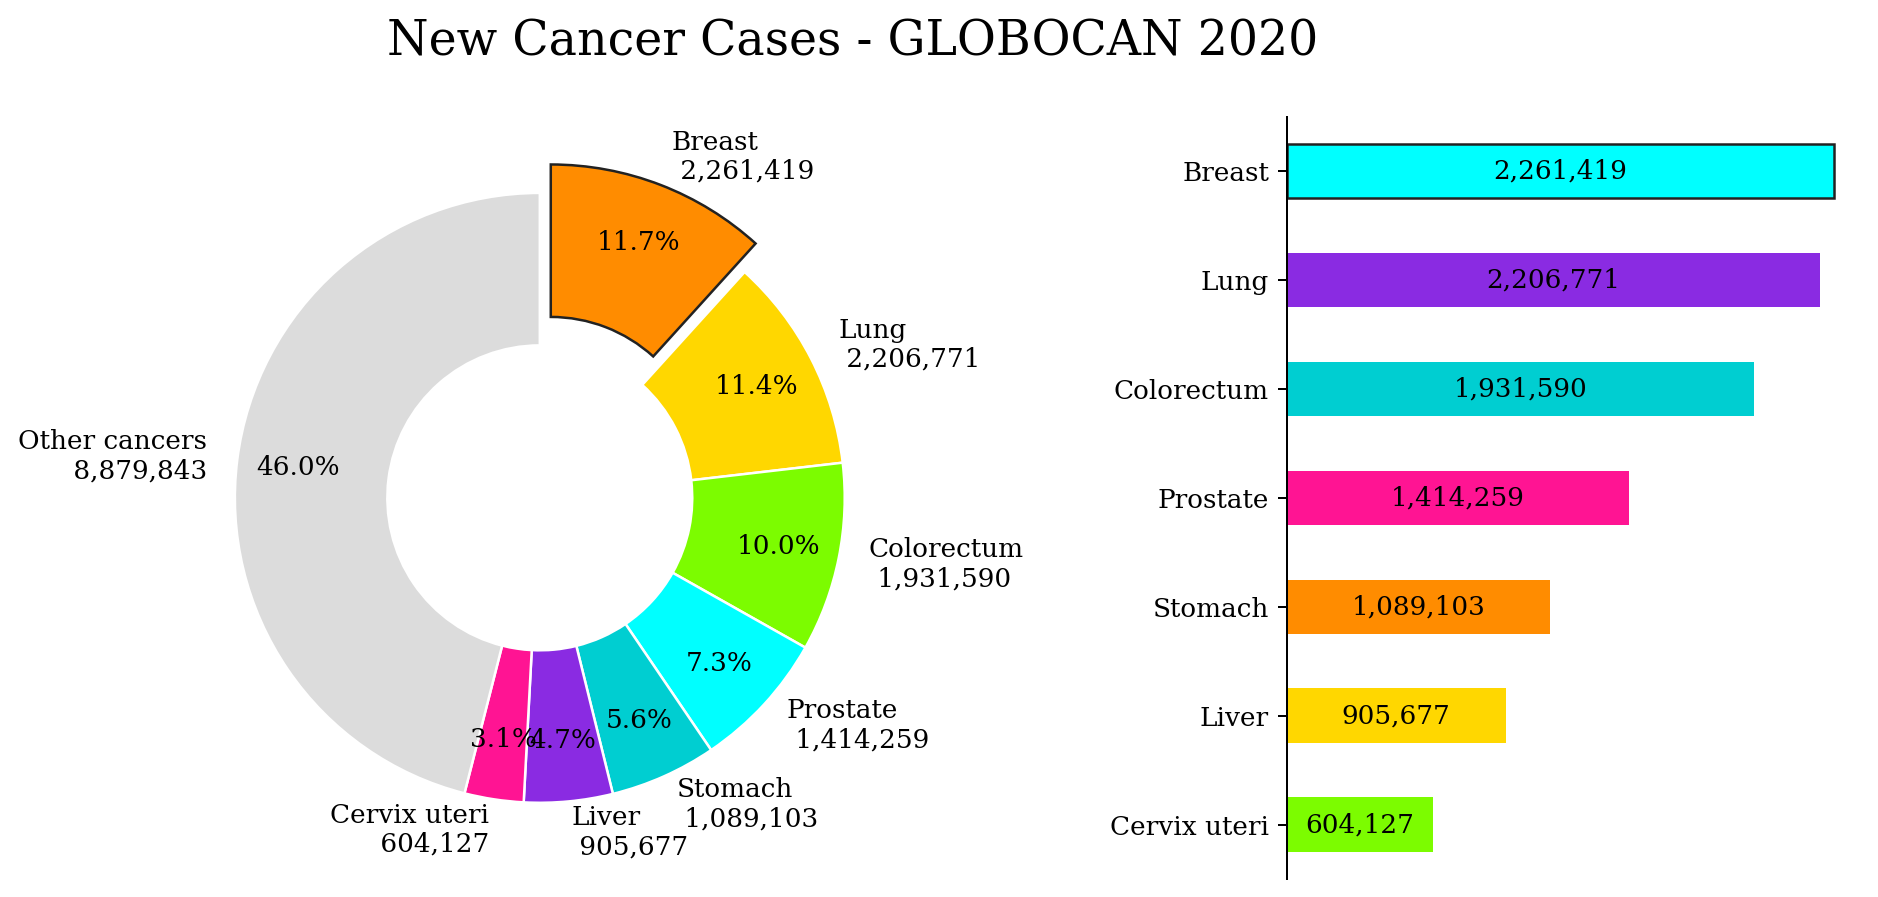

In [ ]:
import matplotlib.pyplot as plt

# Define custom colors for the pie chart
pie_colors = ['#FF8C00', '#FFD700', '#7CFC00', '#00FFFF', '#00CED1', '#8A2BE2', '#FF1493', '#DCDCDC']

# Define custom colors for the bar chart
bar_colors = ['#7CFC00', '#FFD700', '#FF8C00', '#FF1493', '#00CED1', '#8A2BE2', '#00FFFF']

cancer_data = pd.Series({
    "Breast": 2261419,
    "Lung": 2206771,
    "Colorectum": 1931590,
    "Prostate": 1414259,
    "Stomach": 1089103,
    "Liver": 905677,
    "Cervix uteri": 604127,
    "Other cancers": 8879843
})

fig, axes = plt.subplot_mosaic("aab", figsize=(14, 5.5), dpi=180)
fig.suptitle("New Cancer Cases - GLOBOCAN 2020", size=19, weight=500)

# Pie chart with custom colors
pie_chart = cancer_data.plot.pie(colors=pie_colors, startangle=90,
                                 autopct=lambda x: f"{x:.1f}%", pctdistance=0.8,
                                 explode=[0.1] + [0]*7, counterclock=False,
                                 ax=axes["a"], wedgeprops=dict(width=0.5, edgecolor='w'),
                                 labels=[f"{kind}\n {count:,}"
                                         for kind, count in cancer_data.items()])
axes["a"].axis("off")

cancer_data_specific = cancer_data.drop("Other cancers").sort_values()

# Bar chart with custom colors
bar_chart = cancer_data_specific.plot.barh(ax=axes["b"], color=bar_colors)
bar_chart.bar_label(bar_chart.containers[0], [f"{x:,}" for x in cancer_data_specific],
             label_type="center")

axes["b"].spines["bottom"].set_visible(False)
axes["a"].patches[0].set_edgecolor("#222")
axes["b"].patches[-1].set_edgecolor("#222")
axes["b"].xaxis.set_visible(False)


#Exploratory Data Analysis

The file Folds.csv outlines a 5-fold cross-validation strategy which was designed such that training and test images are from different individuals:

In [ ]:
fold_info = pd.read_csv("Folds.csv")
fold_info["label"] = fold_info["filename"].str.extract("(malignant|benign)")
fold_info.head(6)

fold  mag    grp                                           filename   label
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
3     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
4     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
5     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Specify the folder path
folder_path = '/content/drive/MyDrive/BreaKHis_v1/'


Mounted at /content/drive


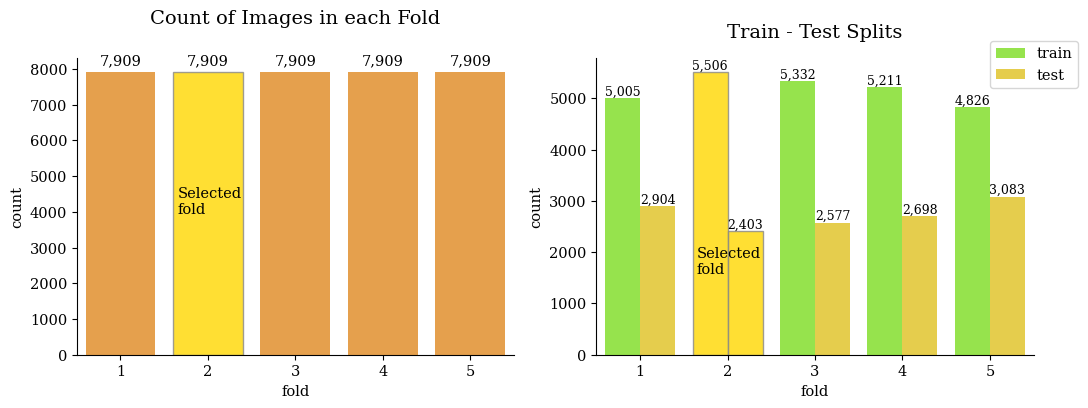

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt

selected_fold = 2
selected_fold_data = fold_info.query("fold == @selected_fold").copy()
selected_fold_data["filename"] = ('/content/drive/MyDrive/BreaKHis_v1/'
                                  + selected_fold_data["filename"])
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11, 4.2), tight_layout=True)


#Magnification factors


established that training models on images with magnification factor at least 200X yields the best results.

Consider the following images from slide-ID 22549AB at different magnification factors:

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(11, 7.5), dpi=180, tight_layout=True)
sample_images = selected_fold_data.groupby("mag", as_index=False).first()
for ax, row in zip(axes.flat, sample_images.itertuples()):
    img = Image.open(row.filename)
    ax.imshow(img)
    ax.set_title(f"{row.mag}X", size=15, pad=25, weight=600)
    ax.text(150, -15, row.filename.split("/")[-1], size=9)
    ax.axis("off")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Use data in selected fold (2) with magnification factor >= 200X
train = selected_fold_data.query("mag >= 40 and grp == 'train'")
test = selected_fold_data.query("mag >= 40 and grp == 'test'")
train.shape, test.shape

((5506, 5), (2403, 5))

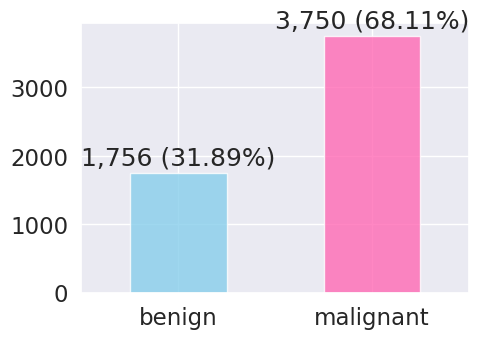

In [ ]:
classes = dict(benign=0, malignant=1)
class_names = list(classes.keys())
label_counts = train["label"].value_counts(ascending=True)
ax = label_counts.plot.bar(color=["skyblue", "hotpink"], alpha=0.8,
                           figsize=(5, 3.5))
ax.bar_label(ax.containers[0], padding=2,
             labels=[f"{x:,} ({x/len(train):.2%})" for x in label_counts])
ax.set_xticklabels(["benign", "malignant"], rotation=0);

In [ ]:
y = train["label"].map(classes)
positive_only_preds = np.ones_like(y)
print(f"Accuracy: {metrics.accuracy_score(y, positive_only_preds):.2%}",
      f"\nROC-AUC:  {metrics.roc_auc_score(y, positive_only_preds):.2%}")

Accuracy: 68.11% 
ROC-AUC:  50.00%


When there's class imbalance in a classification problem, accuracy is an unreliable metric; it becomes easy to achieve high accuracy by just predicting more of the majority class.

To illustrate, a classifier predicting only malignant (1) would get an accuracy score of 67.41% here, without ever identifying any benign cases. But that same model would only achieve an ROC-AUC score of 50% (random, no better than chance).

Text(0.5, 1.1, 'Confusion Matrix Reference')

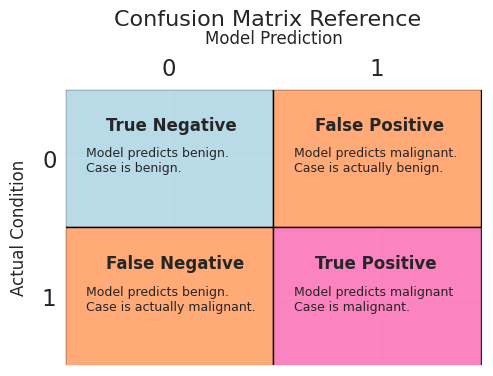

In [ ]:
fig, ax = plt.subplots(figsize=(5.4, 3.6))
ax.axvspan(0, 0.5, 0.5, 1, facecolor="lightblue", alpha=0.8, edgecolor="black")
ax.axvspan(0.5, 1, 0.5, 1, facecolor="#ffaa77", edgecolor="black")
ax.axvspan(0, 0.5, 0, 0.5, facecolor="#ffaa77", edgecolor="black")
ax.axvspan(0.5, 1, 0, 0.5, facecolor="hotpink", alpha=0.8, edgecolor="black")
ax.text(0.1, 0.85, "True Negative", size=12, weight=600)
ax.text(0.05, 0.7, "Model predicts benign.\nCase is benign.", size=9)
ax.text(0.6, 0.85, "False Positive", size=12, weight=600)
ax.text(0.55, 0.7, "Model predicts malignant.\nCase is actually benign.", size=9)
ax.text(0.1, 0.35, "False Negative", size=12, weight=600)
ax.text(0.05, 0.2, "Model predicts benign.\nCase is actually malignant.", size=9)
ax.text(0.6, 0.35, "True Positive", size=12, weight=600)
ax.text(0.55, 0.2, "Model predicts malignant\nCase is malignant.", size=9)
ax.set_xlim(0, 1.005)
ax.xaxis.set_major_locator(ticker.FixedLocator([0.25, 0.75]))
ax.xaxis.set_ticklabels([0, 1])
ax.yaxis.set_major_locator(ticker.FixedLocator([0.25, 0.75]))
ax.yaxis.set_ticklabels([1, 0])
ax.set_ylabel("Actual Condition", size=12, labelpad=10)
ax.set_xlabel("Model Prediction", size=12, labelpad=10)
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticks_position("top")
ax.spines["left"].set_position("zero")
ax.tick_params(pad=0, top=False, left=False)
fig.suptitle("Confusion Matrix Reference", y=1.1, size=16)

# Modify colors for other plots accordingly


#We will use ROC-AUC and a confusion matrix for model evaluation.

Text(0.5, 0.98, 'ROC-AUC and Confusion Matrix for a Perfect Predictor')

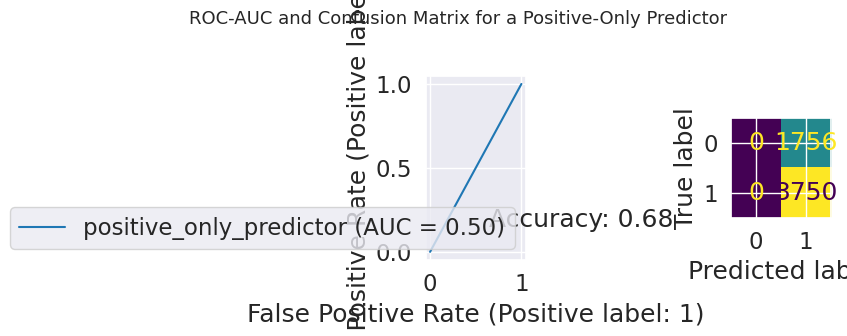

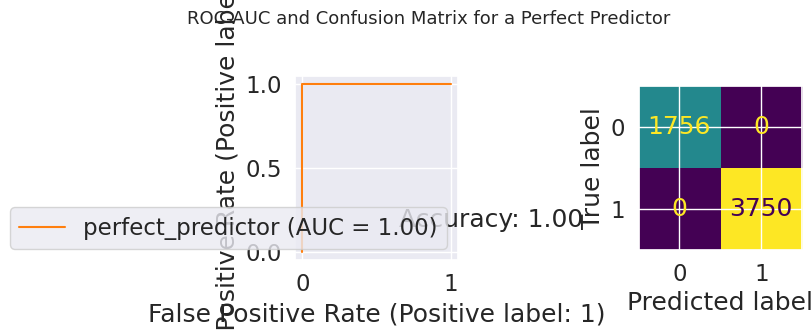

In [ ]:
import seaborn as sb

# Modify the color palette
sb.set_palette(["#1f77b4"])  # Set a single color for all elements

# Plot metrics for positive-only-predictor
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3.5), tight_layout=True)
metrics.RocCurveDisplay.from_predictions(y, positive_only_preds, ax=ax1,
                                         name="positive_only_predictor")
metrics.ConfusionMatrixDisplay.from_predictions(y, positive_only_preds,
                                                ax=ax2, colorbar=False)
ax1.text(0.65, 0.15,
         f"Accuracy: {metrics.accuracy_score(y, positive_only_preds):.2f}")
fig.suptitle("ROC-AUC and Confusion Matrix for a Positive-Only Predictor", size=13)

# Modify the color palette again for the next plot
sb.set_palette(["#ff7f0e"])  # Set a different color for all elements

# Plot metrics for "perfect" predictor
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3.5), tight_layout=True)
metrics.RocCurveDisplay.from_predictions(y, y, ax=ax1, name="perfect_predictor")
ax1.text(0.65, 0.15, f"Accuracy: {metrics.accuracy_score(y, y):.2f}")
metrics.ConfusionMatrixDisplay.from_predictions(y, y, ax=ax2, colorbar=False)
fig.suptitle("ROC-AUC and Confusion Matrix for a Perfect Predictor", size=13)



#Data Ingestion & Preprocessing

Images need to be converted into numeric form for consumption by computer vision models.

We'll use the tensorflow image module to:

i:load the PNG image files

ii:decode the images and convert them to 3D tensors

iii:resize the images to a uniform size (some have 760x460 pixels while some have 760x456).

In [ ]:
IMG_SIZE = 128
BATCH_SIZE = 28


def load_image(filename: str, label: int) -> Tuple[tf.Tensor, str]:
    file = tf.io.read_file(filename)
    img = tf.image.decode_png(file, channels=3)
    img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE)
    return img, label


# Prepare training and validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(
    train["filename"], train["label"].map(classes), random_state=SEED
)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
             .map(load_image).batch(BATCH_SIZE)
validation_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))\
                  .map(load_image).batch(BATCH_SIZE)
# Prepare test dataset
test = test.sample(frac=1, random_state=SEED)  # shuffle test data
test_ds = tf.data.Dataset.from_tensor_slices(
    (test["filename"], test["label"].map(classes))
).map(load_image).batch(BATCH_SIZE)

# Cache and prefetch data for faster training
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(961).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

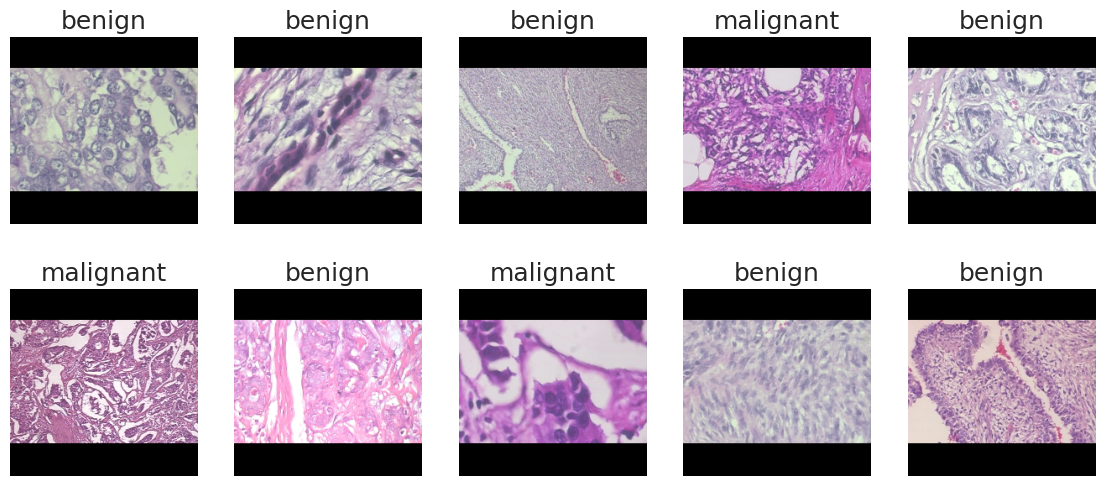

In [ ]:
plt.figure(figsize=(14, 6))
for images, labels in train_ds.take(1):
    labels = labels.numpy()
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype(np.uint8))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
sample_image = load_image(*train[["filename", "label"]].iloc[0])[0]


def plot_augmentations(augmentation_layer: tf.keras.layers.Layer) -> None:
    augment_name = augmentation_layer.name
    fig, (ax0, *axes) = plt.subplots(ncols=4, figsize=(15, 4))
    ax0.imshow(sample_image.numpy().astype("uint8"))
    ax0.set_title("Original", size=14, pad=10)
    ax0.axis("off")
    for idx, ax in enumerate(axes):
        augmented_image = augmentation_layer(sample_image)
        ax.imshow(augmented_image.numpy().astype("uint8"))
        ax.set_title(augment_name.title(), size=14, pad=10)
        ax.axis("off")

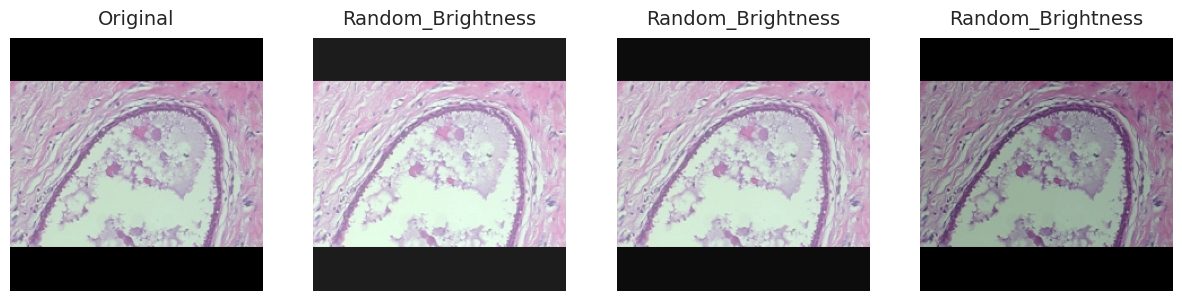

In [ ]:
plot_augmentations(layers.RandomBrightness(0.2))

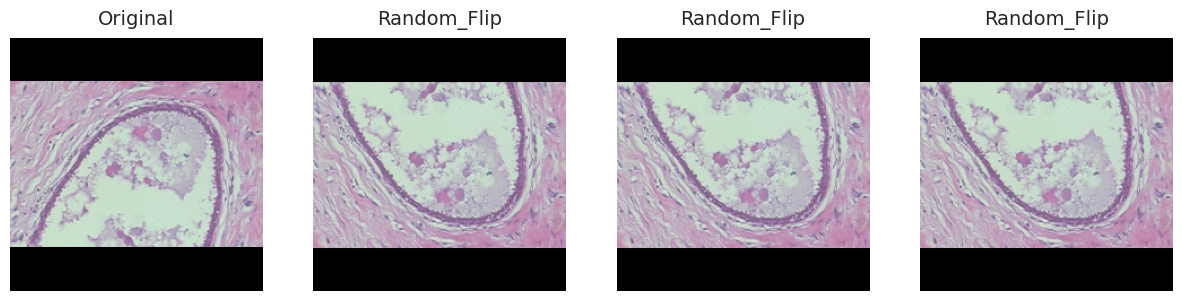

In [ ]:
plot_augmentations(layers.RandomFlip())

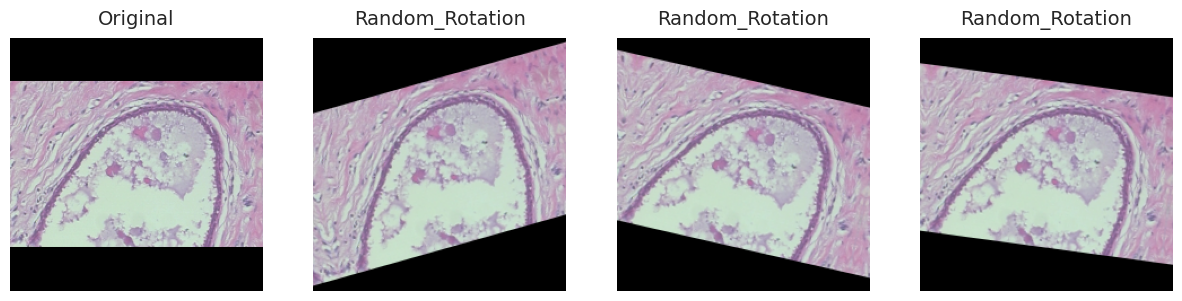

In [ ]:
plot_augmentations(layers.RandomRotation(0.2, seed=SEED))

#Helpers

In [ ]:
class PSOOptimizer(Optimizer):
    def __init__(
        self,
        num_particles=10,
        inertia_weight=0.5,
        cognitive_weight=0.5,
        social_weight=0.5,
        **kwargs
    ):
        super(PSOOptimizer, self).__init__(name="PSOOptimizer", **kwargs)
        self.num_particles = num_particles
        self.inertia_weight = inertia_weight
        self.cognitive_weight = cognitive_weight
        self.social_weight = social_weight

    def __call__(self, learning_rate):
        return self.apply_learning_rate(learning_rate)

    def apply_learning_rate(self, learning_rate):
        self.learning_rate = learning_rate
        return self



In [ ]:
MAX_EPOCHS = 30
BASE_LEARNING_RATE = 0.0005


def compile_and_fit_model(
    model: tf.keras.Model, learning_rate: float = BASE_LEARNING_RATE
) -> tf.keras.callbacks.History:
    optimizer = PSOOptimizer(num_particles=10, inertia_weight=0.5, cognitive_weight=0.5, social_weight=0.5)
    optimizer = optimizer.apply_learning_rate(learning_rate)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.AUC(name="roc_auc"), "binary_accuracy"]
    )

    early_stopping = EarlyStopping(min_delta=1e-4, patience=5, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(factor=0.5, patience=4, verbose=1)

    history = model.fit(
        train_ds,
        validation_data=validation_ds,
        epochs=MAX_EPOCHS,
        callbacks=[early_stopping, reduce_lr]
    )






    # Plot training metrics
    performance_df = pd.DataFrame(history.history)
    fig, axes = plt.subplots(ncols=2, figsize=(11, 4))
    for ax, metric in zip(axes.flat, ["Accuracy", "Loss"]):
        performance_df.filter(like=metric.lower()).plot(ax=ax)
        ax.set_title(metric, size=14, pad=10)
        ax.set_xlabel("epoch")
    return history


def evaluate_model(model: tf.keras.Model, dataset: tf.data.Dataset=test_ds) -> None:
    loss, auc, accuracy = model.evaluate(dataset, verbose=0)
    print(f"\nROC-AUC:   {auc:.5f}",
          f"Accuracy:  {accuracy:.5f}",
          f"Loss:      {loss:.5f}\n", sep="\n")
    # Get labels and predictions for each batch in dataset
    results = [(labels, model.predict(images, verbose=0).reshape(-1))
               for images, labels in dataset.take(-1)]
    labels = np.concatenate([x[0] for x in results])
    preds = np.concatenate([x[1] for x in results])
    # Plot metrics
    fig, axes = plt.subplots(ncols=3, figsize=(15, 4), dpi=160)
    curves = [metrics.RocCurveDisplay, metrics.PrecisionRecallDisplay]
    for ax, curve in zip(axes[:2], curves):
        curve.from_predictions(labels, preds, ax=ax, name=model.name)
    metrics.ConfusionMatrixDisplay.from_predictions(
        labels, preds.round().astype("uint8"), ax=axes[2], colorbar=False,
    )
    titles = ["ROC-AUC Curve", "Precision-Recall Curve", "Confusion Matrix"]
    for ax, title in zip(axes.flat, titles):
        ax.set_title(title, size=14, pad=10)


def plot_predictions(model: tf.keras.Model) -> None:
    plt.figure(figsize=(14, 9))
    for images, labels in test_ds.take(1):
        labels = labels.numpy()
        predicted_labels = model.predict(images).round().astype("uint8").reshape(-1,)
        print("Predicted:", predicted_labels)
        print("Actual:   ", labels)
        for i, (pred, actual) in enumerate(zip(predicted_labels, labels)):
            ax = plt.subplot(4, 7, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if pred == actual:
                plt.title(class_names[labels[i]], color="green", size=9)
            else:
                plt.title(f"{class_names[predicted_labels[i]]}\n"
                          + f"(Actual: {class_names[labels[i]]})",
                          color="red", size=9)
            plt.axis("off")

#Custom Convolutional Neural Network


A Convolutional Neural Network (CNN) is a class of artificial neural networks that is well suited for computer vision problems. It excels at finding patterns (features) in images (see introduction to CNNs).



In [ ]:
custom_model = tf.keras.Sequential([layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Data augmentation
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    # Convolutional block I
    layers.Rescaling(1./255),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    # Convolutional block II
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    # Convolutional block III
    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    # Fully connected layers
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="CustomCNN")
custom_model.summary()

Model: "CustomCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_brightness_1 (Random  (None, 224, 224, 3)      0         
 Brightness)                                                     
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 3)      12        
 ormalization)                                                   
                                                         

Epoch 1/25
148/148 [==============================] - 235s 2s/step - loss: 0.4980 - roc_auc: 0.7940 - binary_accuracy: 0.7815 - val_loss: 0.4994 - val_roc_auc: 0.8674 - val_binary_accuracy: 0.7865 - lr: 5.0000e-04
Epoch 2/25
148/148 [==============================] - 20s 133ms/step - loss: 0.4368 - roc_auc: 0.8413 - binary_accuracy: 0.8290 - val_loss: 0.4432 - val_roc_auc: 0.8810 - val_binary_accuracy: 0.8627 - lr: 5.0000e-04
Epoch 3/25
148/148 [==============================] - 20s 133ms/step - loss: 0.4207 - roc_auc: 0.8503 - binary_accuracy: 0.8411 - val_loss: 0.4025 - val_roc_auc: 0.8850 - val_binary_accuracy: 0.8591 - lr: 5.0000e-04
Epoch 4/25
148/148 [==============================] - 20s 132ms/step - loss: 0.4103 - roc_auc: 0.8560 - binary_accuracy: 0.8423 - val_loss: 0.3733 - val_roc_auc: 0.8944 - val_binary_accuracy: 0.8722 - lr: 5.0000e-04
Epoch 5/25
148/148 [==============================] - 19s 131ms/step - loss: 0.4128 - roc_auc: 0.8554 - binary_accuracy: 0.8404 - val_loss

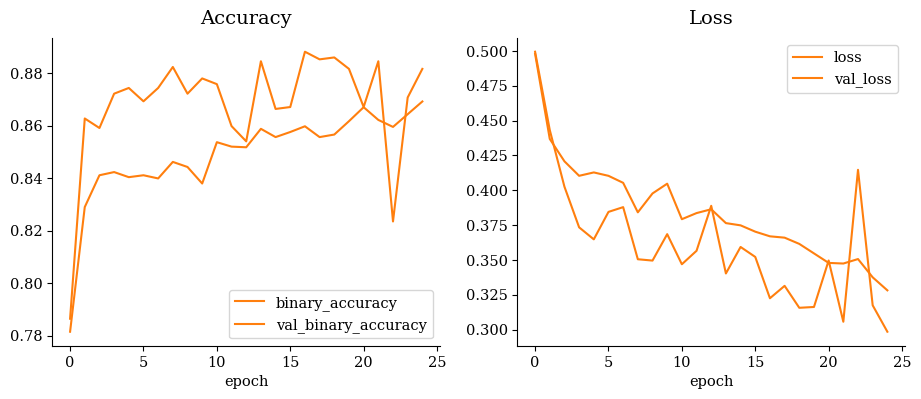

In [ ]:
custom_history = compile_and_fit_model(custom_model)


ROC-AUC:   0.88798
Accuracy:  0.83729
Loss:      0.38155



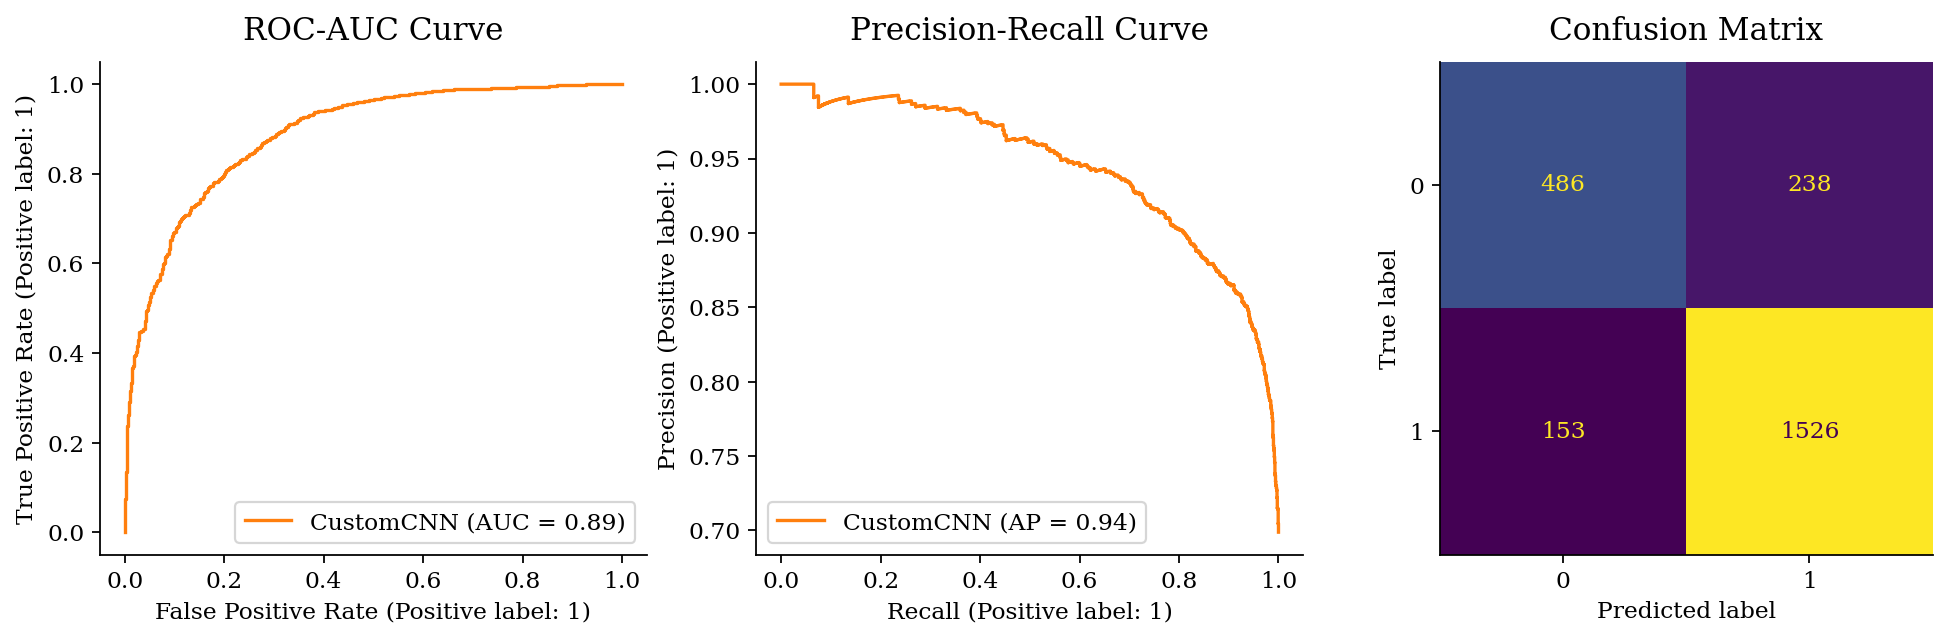

In [ ]:
evaluate_model(custom_model)

1/1 [==============================] - 0s 48ms/step
Predicted: [1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1]
Actual:    [1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 1 1 0 1 1]


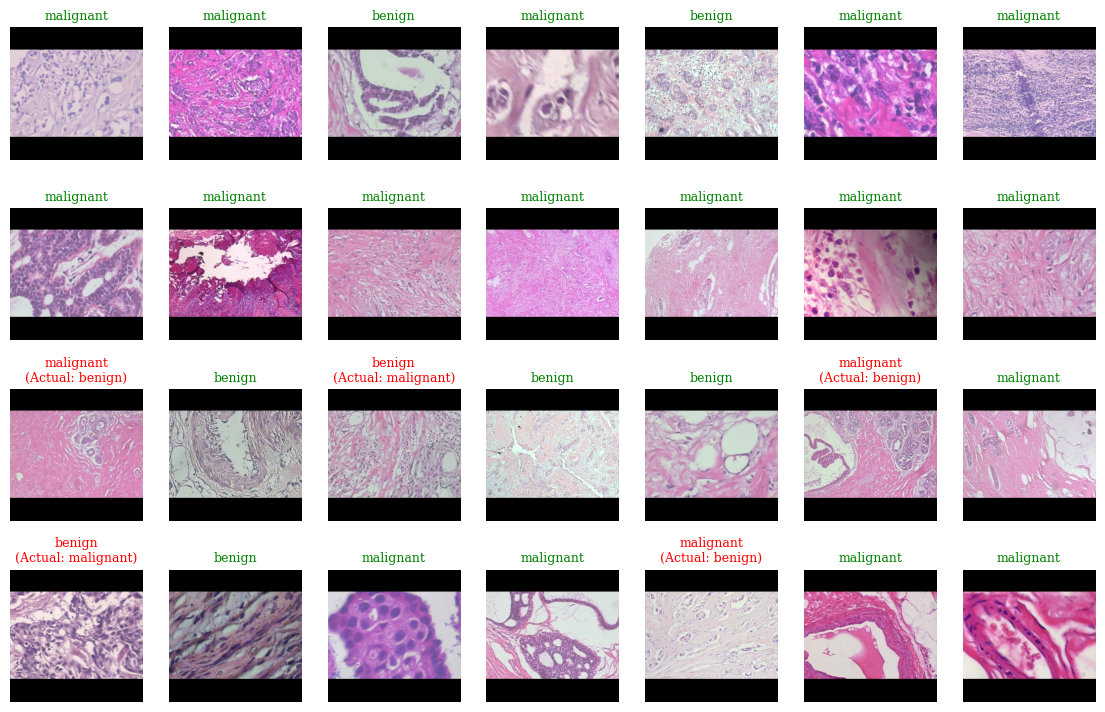

In [ ]:
plot_predictions(custom_model)

#new model....

In [ ]:

custom_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Data augmentation
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    # Convolutional block I
    layers.Rescaling(1./255),
    layers.BatchNormalization(),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # Second Layer
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # Third Layer
    layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),
    # Fourth Layer
    layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),
    # Flattening the layers
    layers.Flatten(),
    # Adding the dense layers
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name="CustomCNN")

custom_model.summary()


Model: "CustomCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_brightness_15 (Rando  (None, 128, 128, 3)      0         
 mBrightness)                                                    
                                                                 
 random_flip_15 (RandomFlip)  (None, 128, 128, 3)      0         
                                                                 
 random_rotation_15 (RandomR  (None, 128, 128, 3)      0         
 otation)                                                        
                                                                 
 rescaling_7 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 batch_normalization_14 (Bat  (None, 128, 128, 3)      12        
 chNormalization)                                                
                                                         

In [ ]:
custom_history = compile_and_fit_model(custom_model)

ValueError: ignored


ROC-AUC:   0.86730
Accuracy:  0.81648
Loss:      0.42884



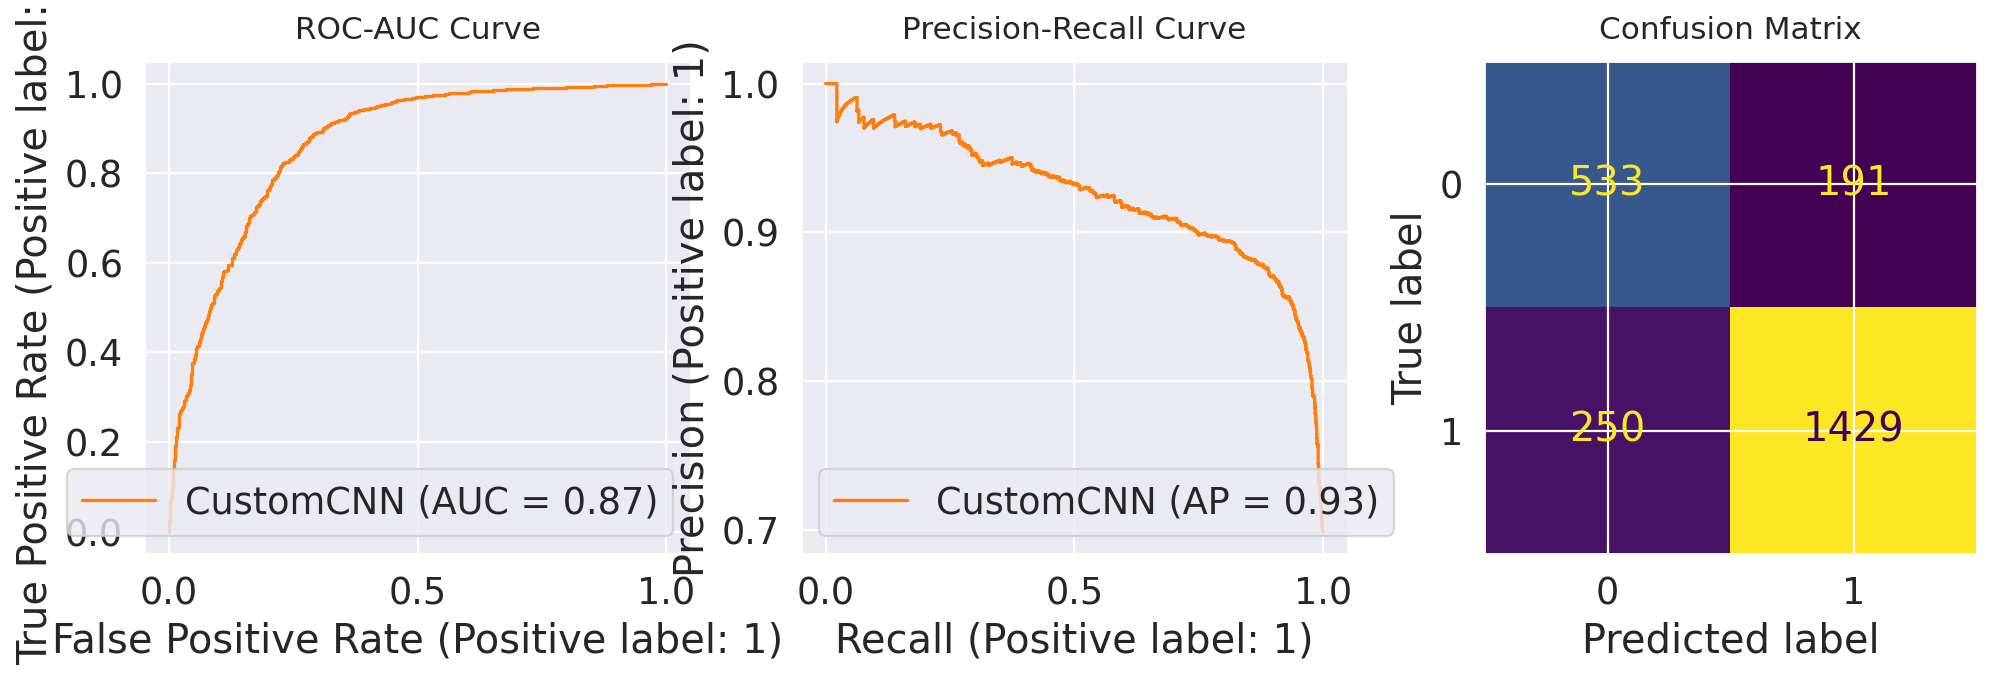

In [ ]:
evaluate_model(custom_model)

#Model with Vgg19

In [ ]:
pretrained_vgg_base = tf.keras.applications.VGG19(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet",
    pooling="avg",
)
pretrained_vgg_base.trainable = False

vgg19_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Data augmentation
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    # VGG19
    layers.Lambda(tf.keras.applications.vgg19.preprocess_input),
    pretrained_vgg_base,
    layers.Dropout(0.5),
    # Fully connected layers
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="VGG19")
vgg19_model.summary()

80134624/80134624 [==============================] - 11s 0us/step
Model: "VGG19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_brightness_2 (Random  (None, 224, 224, 3)      0         
 Brightness)                                                     
                                                                 
 random_flip_2 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                             

Epoch 1/25
148/148 [==============================] - 37s 219ms/step - loss: 0.7963 - roc_auc: 0.6283 - binary_accuracy: 0.6607 - val_loss: 0.5223 - val_roc_auc: 0.8046 - val_binary_accuracy: 0.7269 - lr: 5.0000e-04
Epoch 2/25
148/148 [==============================] - 30s 201ms/step - loss: 0.6215 - roc_auc: 0.7020 - binary_accuracy: 0.6992 - val_loss: 0.4959 - val_roc_auc: 0.8526 - val_binary_accuracy: 0.7908 - lr: 5.0000e-04
Epoch 3/25
148/148 [==============================] - 30s 204ms/step - loss: 0.5728 - roc_auc: 0.7309 - binary_accuracy: 0.7246 - val_loss: 0.4859 - val_roc_auc: 0.8523 - val_binary_accuracy: 0.7858 - lr: 5.0000e-04
Epoch 4/25
148/148 [==============================] - 30s 203ms/step - loss: 0.5571 - roc_auc: 0.7473 - binary_accuracy: 0.7300 - val_loss: 0.4939 - val_roc_auc: 0.8455 - val_binary_accuracy: 0.7531 - lr: 5.0000e-04
Epoch 5/25
148/148 [==============================] - 30s 202ms/step - loss: 0.5306 - roc_auc: 0.7658 - binary_accuracy: 0.7503 - val_lo

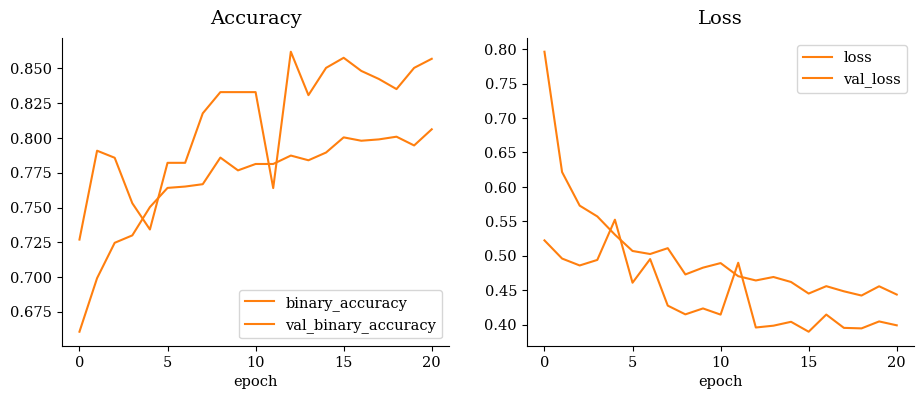

In [ ]:
vgg19_history = compile_and_fit_model(vgg19_model)


ROC-AUC:   0.85002
Accuracy:  0.82355
Loss:      0.43161



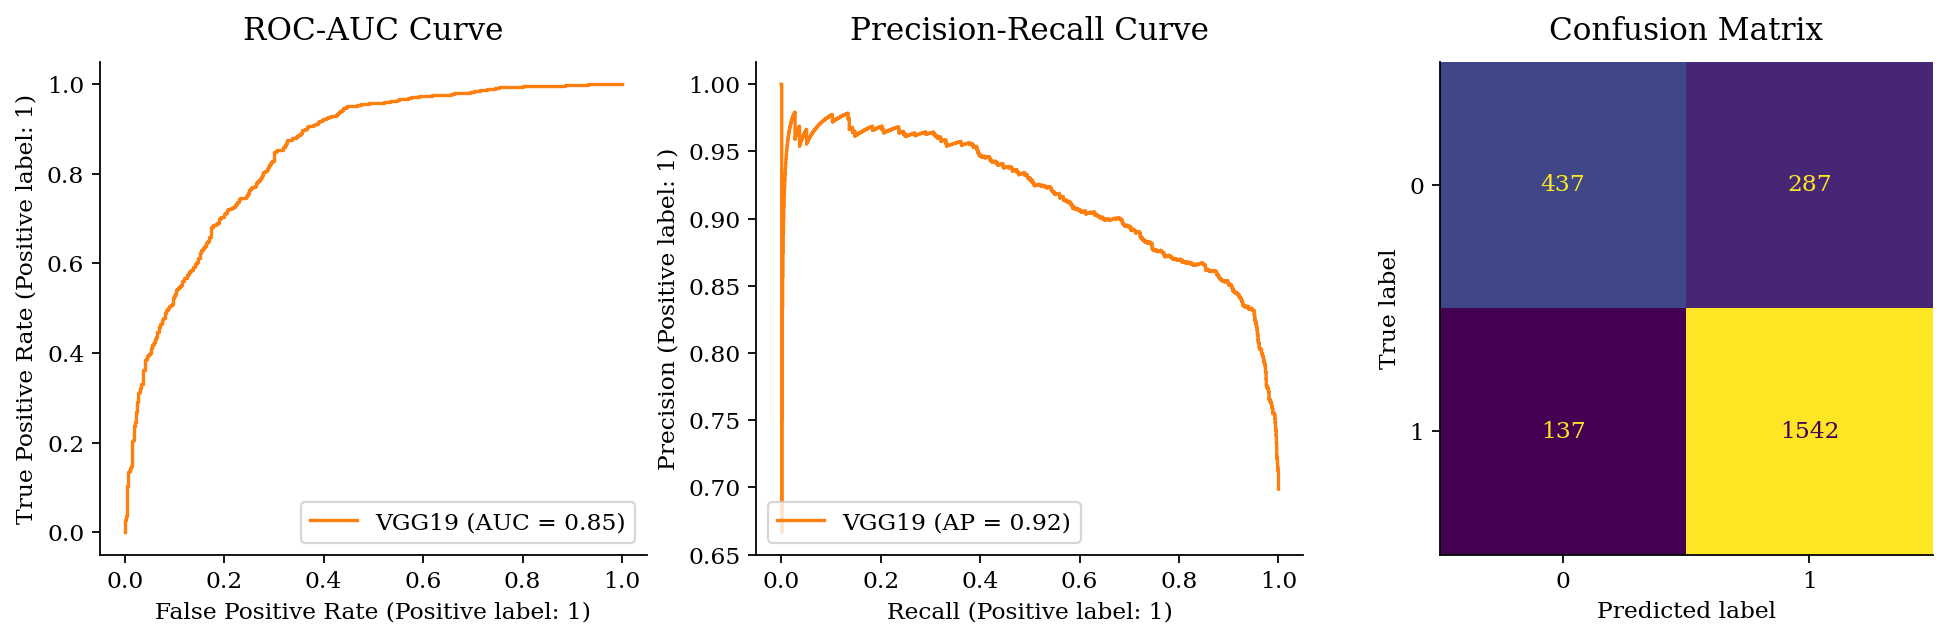

In [ ]:
evaluate_model(vgg19_model)

1/1 [==============================] - 0s 46ms/step
Predicted: [1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1]
Actual:    [1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 1 1 0 1 1]


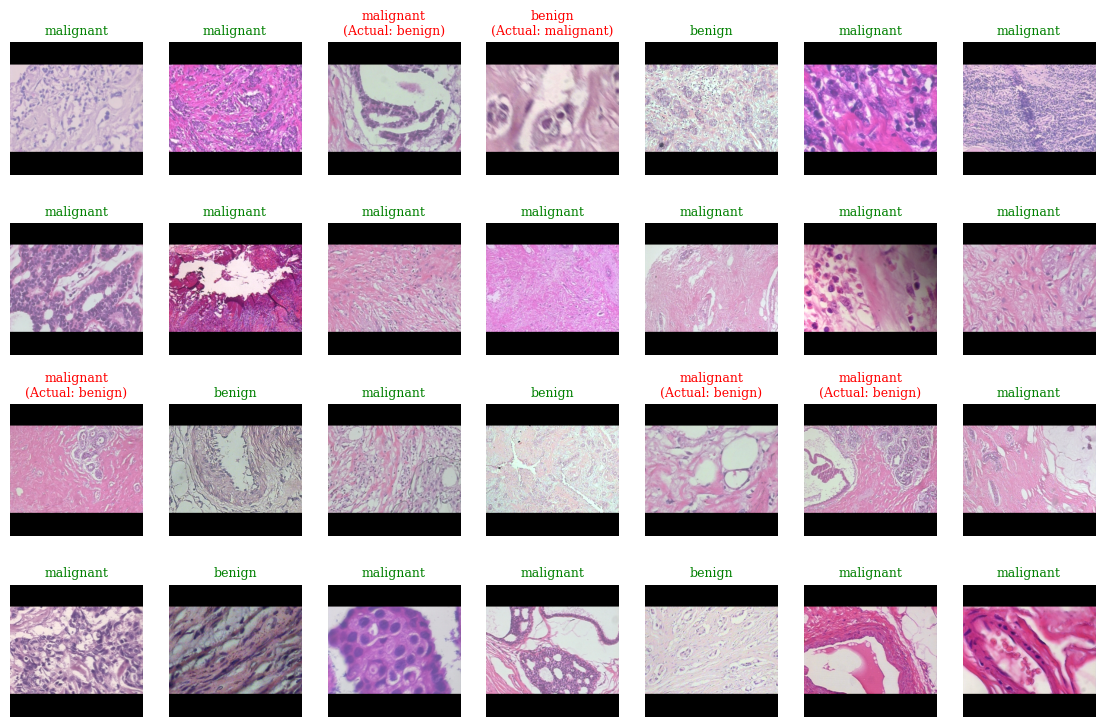

In [ ]:
plot_predictions(vgg19_model)

#Vgg16 Base....

In [ ]:
pretrained_vgg16_base = tf.keras.applications.vgg16.VGG16(
    include_top = False,
    input_shape= (IMG_SIZE, IMG_SIZE, 3),
    weights = "imagenet",
    pooling = "avg",
)

pretrained_vgg16_base.trainable = False


vgg16_model =tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE,3)),

#Data Augmentation

layers.RandomBrightness(0.2, seed = SEED),
layers.RandomFlip(seed= SEED),
layers.RandomRotation(0.2, seed =SEED),

#VGG16
layers.Lambda(tf.keras.applications.vgg16.preprocess_input),
pretrained_vgg16_base,
layers.Dropout(0.5),



# Fully Connected layers
layers.Dense(256, activation="relu"),
layers.Dropout(0.2),
layers.Dense(32, activation="relu"),
layers.Dense(1, activation = "sigmoid")

], name="VGG16")


vgg16_model.summary()

58889256/58889256 [==============================] - 10s 0us/step
Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_brightness_3 (Random  (None, 224, 224, 3)      0         
 Brightness)                                                     
                                                                 
 random_flip_3 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                             

Epoch 1/25
148/148 [==============================] - 31s 177ms/step - loss: 0.6734 - roc_auc: 0.6351 - binary_accuracy: 0.6723 - val_loss: 0.5731 - val_roc_auc: 0.8080 - val_binary_accuracy: 0.7117 - lr: 5.0000e-04
Epoch 2/25
148/148 [==============================] - 25s 170ms/step - loss: 0.5619 - roc_auc: 0.7206 - binary_accuracy: 0.7212 - val_loss: 0.5252 - val_roc_auc: 0.8523 - val_binary_accuracy: 0.7553 - lr: 5.0000e-04
Epoch 3/25
148/148 [==============================] - 24s 164ms/step - loss: 0.5183 - roc_auc: 0.7709 - binary_accuracy: 0.7539 - val_loss: 0.5178 - val_roc_auc: 0.8679 - val_binary_accuracy: 0.7988 - lr: 5.0000e-04
Epoch 4/25
148/148 [==============================] - 25s 167ms/step - loss: 0.5018 - roc_auc: 0.7915 - binary_accuracy: 0.7653 - val_loss: 0.5055 - val_roc_auc: 0.8807 - val_binary_accuracy: 0.8163 - lr: 5.0000e-04
Epoch 5/25
148/148 [==============================] - 25s 169ms/step - loss: 0.4833 - roc_auc: 0.8090 - binary_accuracy: 0.7791 - val_lo

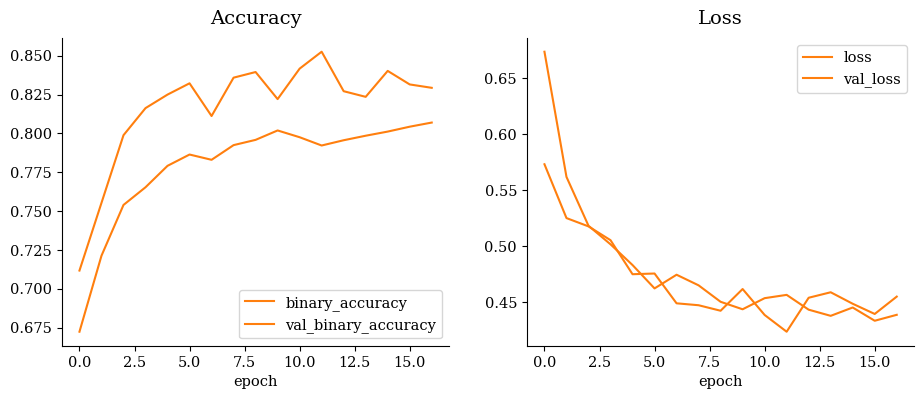

In [ ]:
vgg16_history = compile_and_fit_model(vgg16_model)


ROC-AUC:   0.82512
Accuracy:  0.80982
Loss:      0.47496



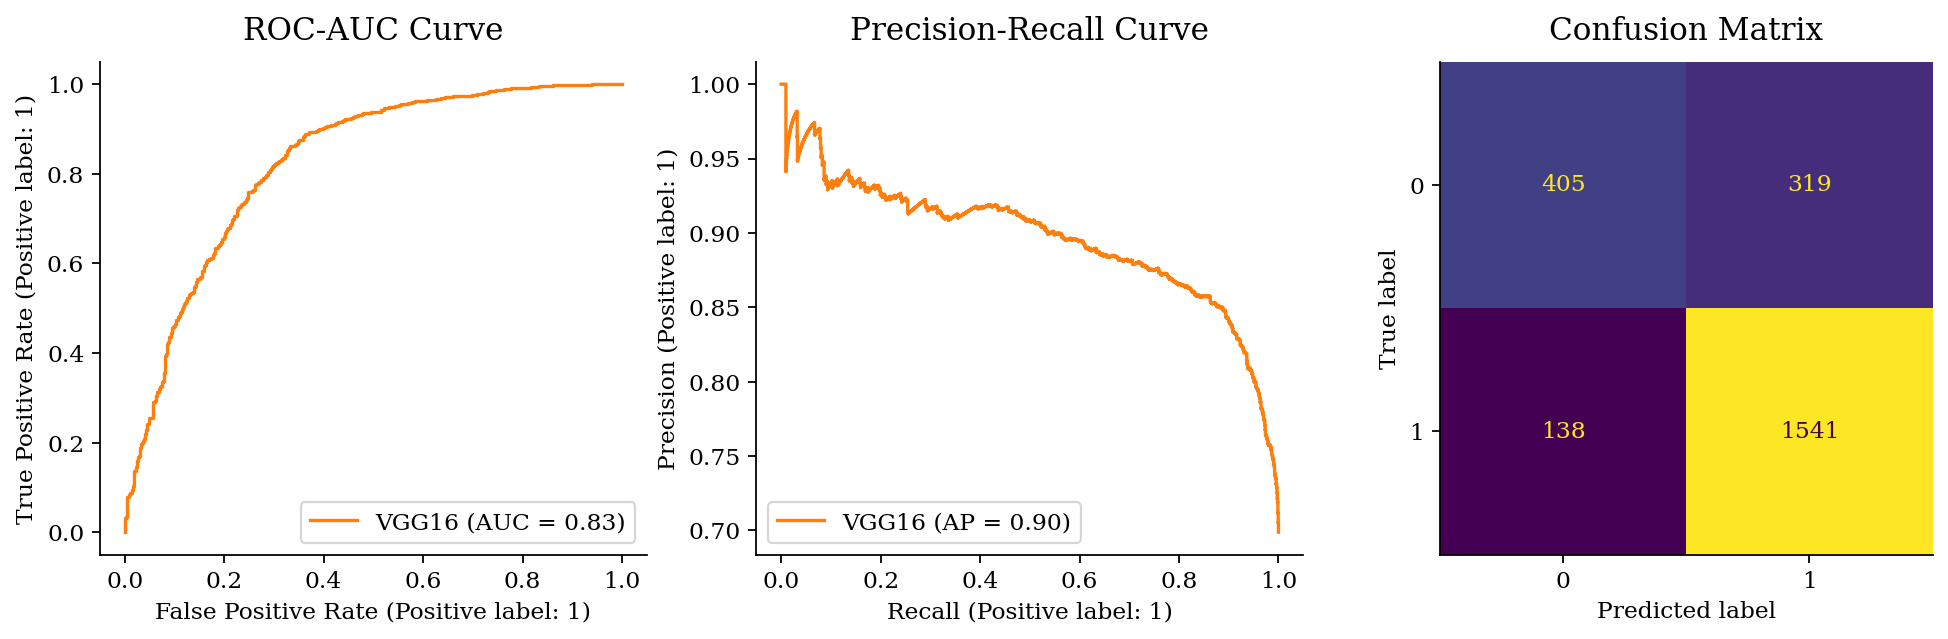

In [ ]:
evaluate_model(vgg16_model)

1/1 [==============================] - 0s 49ms/step
Predicted: [1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1 1]
Actual:    [1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 1 1 0 1 1]


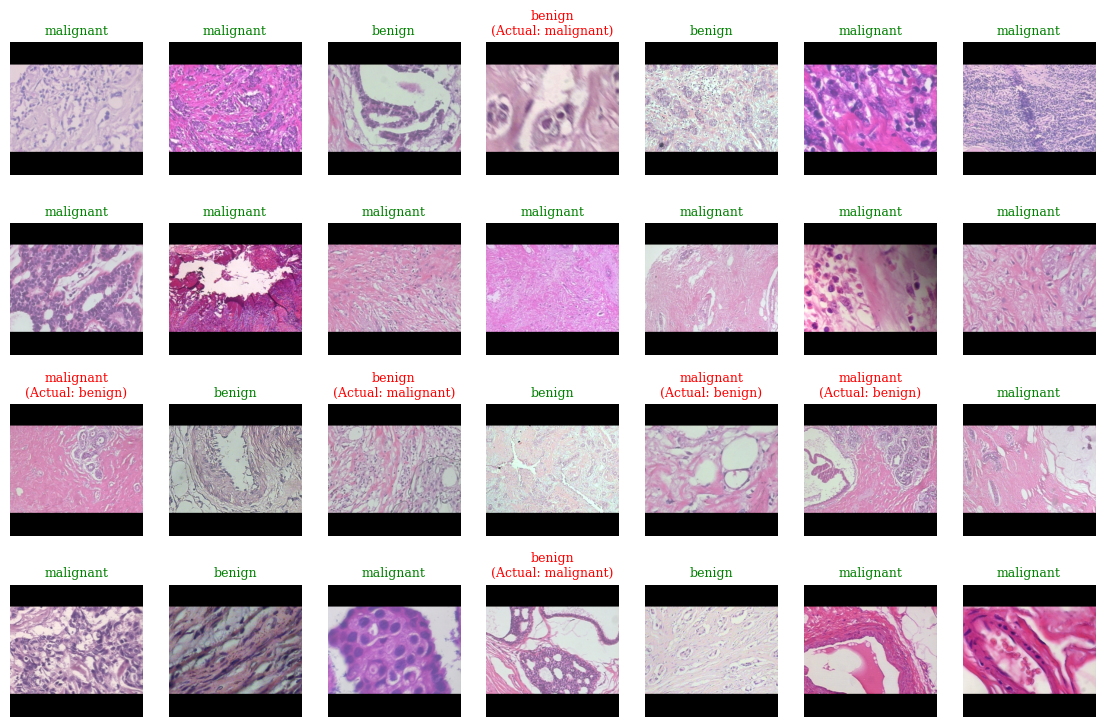

In [ ]:

plot_predictions(vgg16_model)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

pretrained_alexnet_base = tf.keras.applications.alexnet.ALEXNET(
    include_top = False,
    input_shape = (IMG_SIZE, IMG_SIZE, 3))

pretrained_alexnet_base.trainable = False


alexnet_model = tf.keras.Sequential([
    layers.Input(shape = (IMG_SIZE, IMG_SIZE, 3)),


    #DATA AUGMENTATION


    layers.RandomBrightness(0.2, seed =SEED),
    layers.RandomFlip(seed = SEED),
    layers.RandomRotation(0.2, seed= SEED),


    #ALEXNET.....

    layers.Lambda(tf.keras.applications.alexnet.preprocess_input),
    pretrained_alexnet,
    layers.Dropout(0.5),


    #FULLY CONNECTED LAYERS......

    layers.Dense(4096, activation = "relu"),
    layers.Dropout(0.5),
    layers.Dense(4096, activation = "relu"),
    layers.Dropout(0.5),
    layers.Dense(1000, activation = "relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation ="sigmoid")

    ], name ="alexnet")


alexnet_model.summary()

AttributeError: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def create_alexnet_model():
    model = tf.keras.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2)),

        layers.Conv2D(256, (5, 5), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2)),

        layers.Conv2D(384, (3, 3), activation='relu', padding="same"),
        layers.Conv2D(384, (3, 3), activation='relu', padding="same"),
        layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2)),

        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1000, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

alexnet_model = create_alexnet_model()
alexnet_model.summary()


In [ ]:
alexnet_history = compile_and_fit_model(alexnet_model)

In [ ]:
!pip install --upgrade nni

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: filelock
    Found existing installation: filelock 3.12.0
    Uninstalling filelock-3.12.0:
      Successfully uninstalled filelock-3.12.0


#Prune your model